# Лабораторная работа 5

Градиентный бустинг с CatBoost

Выполнил: Новицкий Никита (6132-010402D)

In [1]:
import pandas as pd
import numpy as np
from catboost import *
from catboost import CatBoostClassifier
from catboost.datasets import amazon
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay, mean_absolute_error, mean_squared_error
from sklearn.metrics import plot_roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score
from warnings import filterwarnings
filterwarnings("ignore")

Подобрать набор данных для классификации (количество классов не имеет значения) и регрессии. Важно наличие числовых и категориальных признаков в данных. Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений. Можно работать на тех же данных, что и в предыдущей Л.Р.: в этом случае сравнить с результатами лучшего классификатора из предыдущей работы.

In [2]:
amazon_train, amazon_test = amazon()

In [3]:
amazon_train.head(10)

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325
5,0,45333,14561,117951,117952,118008,118568,118568,19721,118570
6,1,25993,17227,117961,118343,123476,118980,301534,118295,118982
7,1,19666,4209,117961,117969,118910,126820,269034,118638,126822
8,1,31246,783,117961,118413,120584,128230,302830,4673,128231
9,1,78766,56683,118079,118080,117878,117879,304519,19721,117880


In [4]:
amazon_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


In [5]:
amazon_train.describe()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,0.942110,42923.916171,25988.957979,116952.627788,118301.823156,118912.779914,125916.152644,170178.369648,183703.408893,119789.430132
std,0.233539,34173.892702,35928.031650,10875.563591,4551.588572,18961.322917,31036.465825,69509.462130,100488.407413,5784.275516
min,0.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.000000,117880.000000
25%,1.000000,20299.000000,4566.000000,117961.000000,118102.000000,118395.000000,118274.000000,117906.000000,118363.000000,118232.000000
50%,1.000000,35376.000000,13545.000000,117961.000000,118300.000000,118921.000000,118568.000000,128696.000000,119006.000000,118570.000000
75%,1.000000,74189.000000,42034.000000,117961.000000,118386.000000,120535.000000,120006.000000,235280.000000,290919.000000,119348.000000
max,1.000000,312153.000000,311696.000000,311178.000000,286791.000000,286792.000000,311867.000000,311867.000000,308574.000000,270691.000000


1 Применить классификатор CatBoostClassifier к вашему набору данных. Обратите внимание, что catboost умеет работать с категориальными признаками (параметр cat_features - список индексов категориальных признаков), поэтому использование pd.factorize / pd.get_dummies здесь лишнее.

1) Вывести итерацию с наилучшим значением AUC (для бинарной классификации) или наилучшим значением Logloss.

2) Вывести значения метрик качества классификации на тестовых данных (accuracy и precision / recall / AUC, если применимо).

3) В случае бинарной классификации на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.

In [6]:
X, y = amazon_train.drop("ACTION", axis=1), amazon_train["ACTION"]

In [7]:
features = list(range(0, X.shape[1]))
print(features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.35, random_state=42)

In [9]:
model = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.15,
    custom_loss=['AUC', 'Accuracy']
)

model.fit(
    X_train, y_train,
    cat_features=features,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Посмотрим на лучшие параметры модели, лучшую итерацию и выведем лучшие score по метрикам

In [10]:
print(f"Model is fitted: {model.is_fitted()}")
print(f"Model params: {model.get_params()}")
print(f"Best iteration: {model.get_best_iteration()}")
print(f"Best score: {model.best_score_}")

Model is fitted: True
Model params: {'iterations': 200, 'learning_rate': 0.15, 'random_seed': 63, 'custom_loss': ['AUC', 'Accuracy']}
Best iteration: 163
Best score: {'learn': {'Accuracy': 0.9594559246664923, 'Logloss': 0.13407863416815255}, 'validation': {'Accuracy': 0.950093896713615, 'Logloss': 0.16184030230994714, 'AUC': 0.8388822835512026}}


Посчитаем значения метрик

In [11]:
print(f"Accuracy: {accuracy_score(y_test, model.predict(X_test))}")
print(f"AUC: {roc_auc_score(y_test, model.predict(X_test))}")
print(f"Precision: {precision_score(y_test, model.predict(X_test))}")
print(f"Recall: {recall_score(y_test, model.predict(X_test))}")

Accuracy: 0.9496713615023474
AUC: 0.6235320760571389
Precision: 0.9560729716754681
Recall: 0.9921781586289359


ROC-AUC кривая

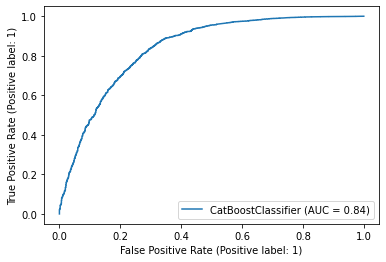

In [12]:
plot_roc_curve(model, X_test, y_test)

PRC-кривая и PRC-AUC

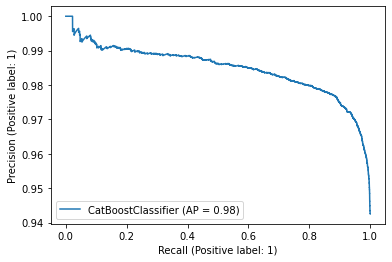

In [13]:
PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="CatBoostClassifier")

2 Применить регрессию CatBoostRegressor к набору данных для регрессии. Вывести номер итерации и значения метрик (MAE и MSE) для наилучшей итерации. Обратите внимание, что в задаче восстановления регрессии целевая переменная имеет непрерывные значения.

In [14]:
model_regressor = CatBoostRegressor(
    custom_metric=["MAE", "RMSE"], 
    cat_features=features
)

model_regressor.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
print(f"Best iteration: {model_regressor.get_best_iteration()}")
print(f"Best score: {model_regressor.get_best_score()}")
print(f"Model params: {model_regressor.get_params()}")
print(f"MAE: {mean_absolute_error(y_test, model_regressor.predict(X_test))}")
print(f"MSE: {mean_squared_error(y_test, model_regressor.predict(X_test))}")

Best iteration: 471
Best score: {'learn': {'MAE': 0.0761874703468223, 'RMSE': 0.17798657077789765}, 'validation': {'MAE': 0.08877611622739962, 'RMSE': 0.20372781833643785}}
Model params: {'loss_function': 'RMSE', 'custom_metric': ['MAE', 'RMSE'], 'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8]}
MAE: 0.08932971247740873
MSE: 0.04150502396412461
